# Creating an Generative Advesarial Network from the [Free Music Archive dataset](https://github.com/mdeff/fma)

##Problem
Can we use the FMA dataset to create artificial music?

Generative Adversarial Networks have become quite common in image generation, but remain relatively unexplored in music.

From my reserach, this will be the first GAN created using the FMA dataset. Indeed, there are few GANs that use mp3 data at all. Most use midi files. 





In [34]:
from __future__ import absolute_import, division, print_function, unicode_literals
import keras
keras.__version__
import os
import pathlib
import functools
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt


!pip install pydub

from pydub import AudioSegment
from os import path



# from google.colab import drive
# drive.mount('/gdrive', force_remount=True)


#Examining Dataset
FMA consists of 917 GB of Creative Commons-licensed audio from 106,574 tracks from 16,341 artists and 14,854 albums in mp3 format. The dataset also consists of computed features, metadata, tags, and associated freeform text such as biographies ([Defferard et alt.](https://arxiv.org/abs/1612.01840)). The only part of this dataset that I beleive is relevant to my project is the actual mp3 data itself.

Download metadata for the Free Music Archive dataset:

In [0]:
fma_metadata = keras.utils.get_file(origin='https://os.unil.cloud.switch.ch/fma/fma_metadata.zip', fname='fma_metadata.zip',extract=True)
fma_metadata = pathlib.Path(fma_metadata)


Given limitations of Google Colab, I only examine a  subset of the data in this IPR. Namely, the lack of ability to conveniently store 917 GB of data. The subset I examine is named `fma_small` and consists of 8,000 tracks of 30 seconds each. I will use this dataset to create a working network that I will then train on the whole dataset on an EECS machine.

In [0]:
fma_music_small = keras.utils.get_file(origin='https://os.unil.cloud.switch.ch/fma/fma_small.zip', fname='fma_small.zip',extract=True)
fma_music_small = pathlib.Path(fma_music_small)

View headers from metadata


In [53]:
metadata = pd.read_csv(os.path.join('/root/.keras/datasets/fma_metadata','tracks.csv'))
metadata.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,album,album.1,album.2,album.3,album.4,album.5,album.6,album.7,album.8,album.9,album.10,album.11,album.12,artist,artist.1,artist.2,artist.3,artist.4,artist.5,artist.6,artist.7,artist.8,artist.9,artist.10,artist.11,artist.12,artist.13,artist.14,artist.15,artist.16,set,set.1,track,track.1,track.2,track.3,track.4,track.5,track.6,track.7,track.8,track.9,track.10,track.11,track.12,track.13,track.14,track.15,track.16,track.17,track.18,track.19
0,NaN,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type,active_year_begin,active_year_end,associated_labels,bio,comments,date_created,favorites,id,latitude,location,longitude,members,name,related_projects,tags,website,wikipedia_page,split,subset,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
1,track_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.0583238,New Jersey,-74.4056612,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:12,2008-11-26 00:00:00,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.0583238,New Jersey,-74.4056612,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,medium,256000,0,NaN,2008-11-26 01:48:14,2008-11-26 00:00:00,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
4,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.0583238,New Jersey,-74.4056612,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:20,2008-11-26 00:00:00,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World


The data is organized into folders, each containing audio files labeled by track_id

In [40]:
!ls /root/.keras/datasets/fma_small

000  012  024  036  048  060  072  084	096  108  120  132  144  checksums
001  013  025  037  049  061  073  085	097  109  121  133  145  README.txt
002  014  026  038  050  062  074  086	098  110  122  134  146
003  015  027  039  051  063  075  087	099  111  123  135  147
004  016  028  040  052  064  076  088	100  112  124  136  148
005  017  029  041  053  065  077  089	101  113  125  137  149
006  018  030  042  054  066  078  090	102  114  126  138  150
007  019  031  043  055  067  079  091	103  115  127  139  151
008  020  032  044  056  068  080  092	104  116  128  140  152
009  021  033  045  057  069  081  093	105  117  129  141  153
010  022  034  046  058  070  082  094	106  118  130  142  154
011  023  035  047  059  071  083  095	107  119  131  143  155


Viewing contents of one folder...

In [41]:
!ls /root/.keras/datasets/fma_small/000

000002.mp3  000200.mp3	000424.mp3  000666.mp3	000709.mp3  000890.mp3
000005.mp3  000203.mp3	000459.mp3  000667.mp3	000714.mp3  000892.mp3
000010.mp3  000204.mp3	000534.mp3  000676.mp3	000715.mp3  000897.mp3
000140.mp3  000207.mp3	000540.mp3  000690.mp3	000716.mp3  000993.mp3
000141.mp3  000210.mp3	000546.mp3  000694.mp3	000718.mp3  000995.mp3
000148.mp3  000211.mp3	000574.mp3  000695.mp3	000777.mp3  000997.mp3
000182.mp3  000212.mp3	000602.mp3  000704.mp3	000814.mp3  000998.mp3
000190.mp3  000213.mp3	000615.mp3  000705.mp3	000821.mp3
000193.mp3  000255.mp3	000620.mp3  000706.mp3	000822.mp3
000194.mp3  000256.mp3	000621.mp3  000707.mp3	000825.mp3
000197.mp3  000368.mp3	000625.mp3  000708.mp3	000853.mp3


Viewing contents of another folder...

In [42]:
!ls /root/.keras/datasets/fma_small/001

001039.mp3  001193.mp3	001417.mp3  001663.mp3	001687.mp3  001733.mp3
001040.mp3  001195.mp3	001427.mp3  001666.mp3	001688.mp3  001735.mp3
001066.mp3  001196.mp3	001443.mp3  001673.mp3	001689.mp3  001736.mp3
001069.mp3  001197.mp3	001482.mp3  001680.mp3	001701.mp3  001883.mp3
001073.mp3  001249.mp3	001510.mp3  001681.mp3	001702.mp3  001891.mp3
001075.mp3  001259.mp3	001544.mp3  001682.mp3	001703.mp3  001893.mp3
001082.mp3  001270.mp3	001642.mp3  001683.mp3	001704.mp3  001924.mp3
001083.mp3  001276.mp3	001644.mp3  001684.mp3	001706.mp3  001925.mp3
001087.mp3  001277.mp3	001649.mp3  001685.mp3	001720.mp3  001929.mp3
001102.mp3  001278.mp3	001661.mp3  001686.mp3	001732.mp3  001930.mp3


# Data Preprocessing (in progress)

The first step is to convert the mp3 file into a tensor

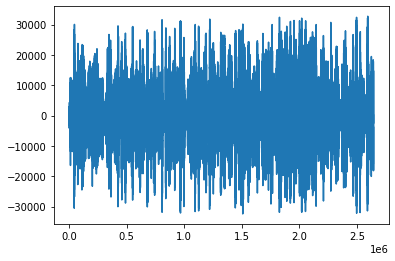

In [49]:

import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/41109652/how-to-read-ogg-or-mp3-audio-files-in-a-tensorflow-graph
dataset = tf.data.Dataset.list_files('/root/.keras/datasets/fma_small/000/*')

def decode_mp3(mp3_path):
    mp3_audio = AudioSegment.from_file(mp3_path, format="mp3")
    return mp3_audio.get_array_of_samples()
    
src = "/root/.keras/datasets/fma_small/000/000002.mp3"


data = decode_mp3(src)
plt.plot(data)
plt.show()

In [51]:
data_tensor = tf.convert_to_tensor(data)
data_tensor.shape

TensorShape([Dimension(2643934)])

#Desired output
The fully trained model will take an input of random noise and generate an mp3 audio file.

#Potential challenges
Since most existing work using MIDI files, not sequential sampled data like an mp3 file, my expectations for a result are very low. Specific challenges I expect to encounter:
1. Difficulty extracting useful patterns due to the complexity of sound data
2. The audio is mixed lyrical and instrumental, so the combination of data types could introduce confusion

#Next steps:
1. Read ahead in Chollet on GANs
2. Continue data-preprocessing
3. Create initial model
4. Develop script for execution on USMA machine